In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

train = pd.read_csv('data_a/train.csv')
test = pd.read_csv('data_a/test.csv')

#提出用
sample_submit = pd.read_csv('data_a/sample_submit.csv',header=None)

In [3]:
#前処理用に結合

all_data = pd.concat([train,test],sort=False)

In [4]:
#欠損の確認

all_data.isnull().sum()

id                            0
accommodates                  0
amenities                     0
bathrooms                   200
bed_type                      0
bedrooms                     91
beds                        131
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
property_type                 0
review_scores_rating      16722
room_type                     0
thumbnail_url              8216
zipcode                     966
y                         18528
dtype: int64

In [5]:
train.head(5)

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,NaN,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,100%,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,100%,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,100%,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,100%,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


In [6]:
all_data.shape

(74111, 29)

In [7]:
#簡単に相関を確認

df_corr = train.corr()
df_corr

,id,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,y
id,1.000000,0.005027,0.005182,0.002463,0.005736,-0.007358,-0.005771,0.004658,0.002307,-0.001129
accommodates,0.005027,1.000000,0.502278,0.708510,0.806654,-0.079395,-0.086365,0.042320,-0.017824,0.522330
bathrooms,0.005182,0.502278,1.000000,0.586366,0.524847,-0.135427,-0.132046,-0.040262,0.006698,0.456044
bedrooms,0.002463,0.708510,0.586366,1.000000,0.708230,-0.057502,-0.074027,-0.033761,0.009996,0.495830
beds,0.005736,0.806654,0.524847,0.708230,1.000000,-0.080307,-0.082434,0.030914,-0.027839,0.435603
latitude,-0.007358,-0.079395,-0.135427,-0.057502,-0.080307,1.000000,0.896581,-0.016439,-0.035133,-0.028940
longitude,-0.005771,-0.086365,-0.132046,-0.074027,-0.082434,0.896581,1.000000,-0.048660,-0.050019,-0.056236
number_of_reviews,0.004658,0.042320,-0.040262,-0.033761,0.030914,-0.016439,-0.048660,1.000000,0.012144,-0.068944
review_scores_rating,0.002307,-0.017824,0.006698,0.009996,-0.027839,-0.035133,-0.050019,0.012144,1.000000,0.065896
y,-0.001129,0.522330,0.456044,0.495830,0.435603,-0.028940,-0.056236,-0.068944,0.065896,1.000000


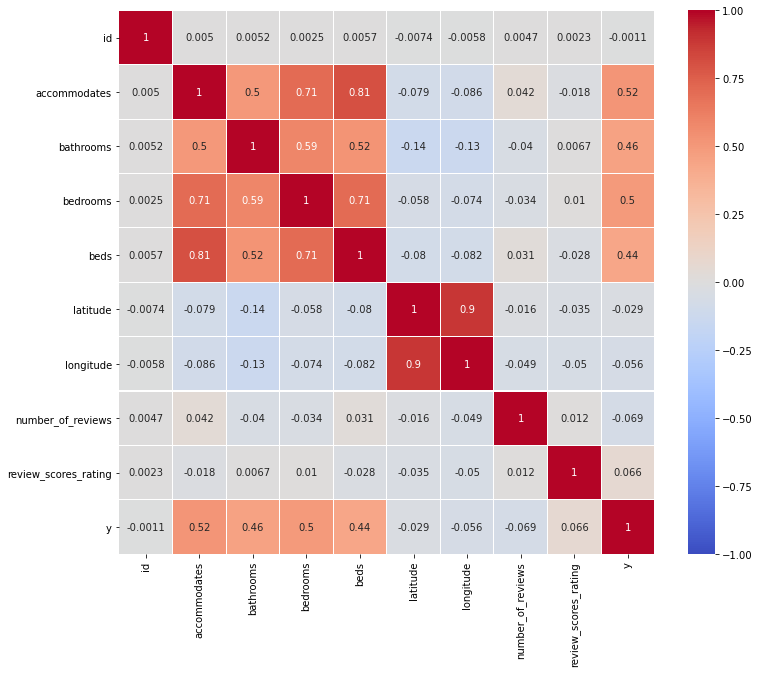

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr,vmin=-1.0, vmax=1, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

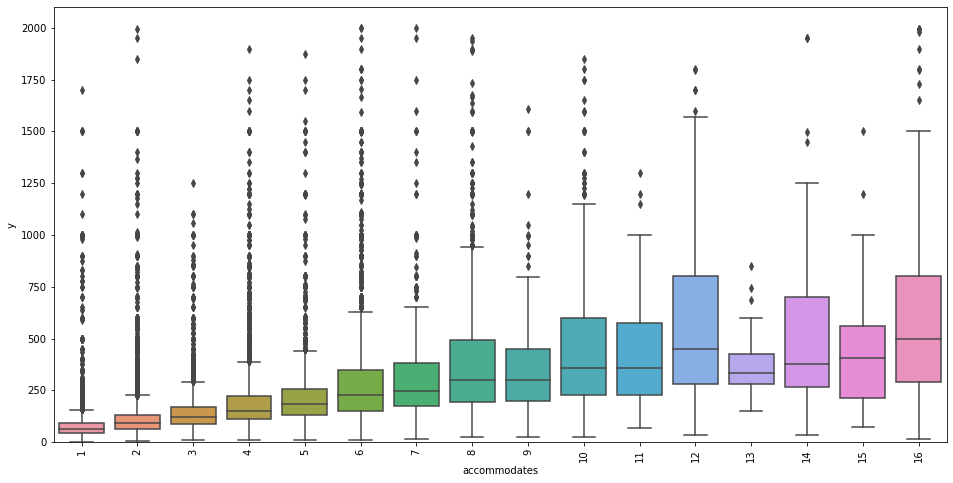

In [9]:
#収容可能人数

var = 'accommodates'
data = pd.concat([train['y'],train[var]],axis=1)
f, ax =plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var,y='y',data=data)
fig.axis(ymin=0,ymax=2100)
plt.xticks(rotation=90);

#medianも比例して推移しているので以下同傾向であると予測

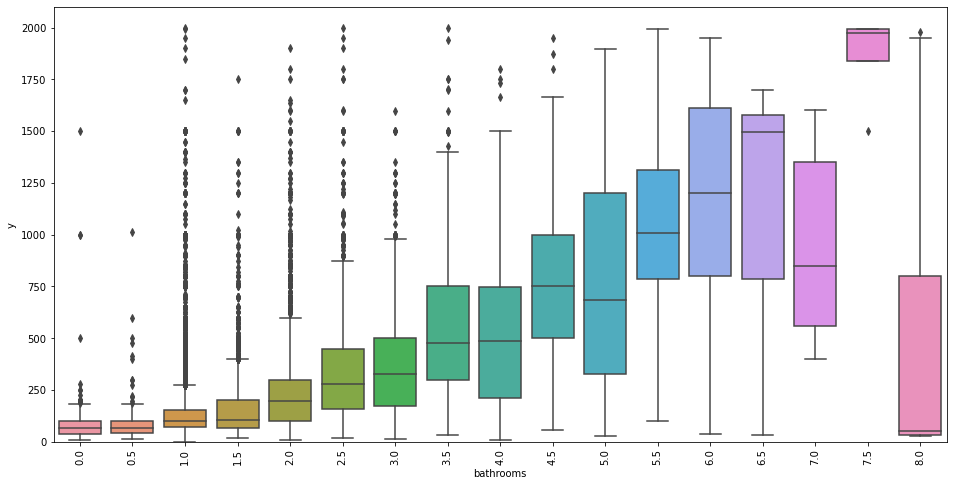

In [10]:
#風呂数

var = 'bathrooms'
data = pd.concat([train['y'],train[var]],axis=1)
f, ax = plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var,y='y',data=data)
fig.axis(ymin=0, ymax=2100)
plt.xticks(rotation=90);

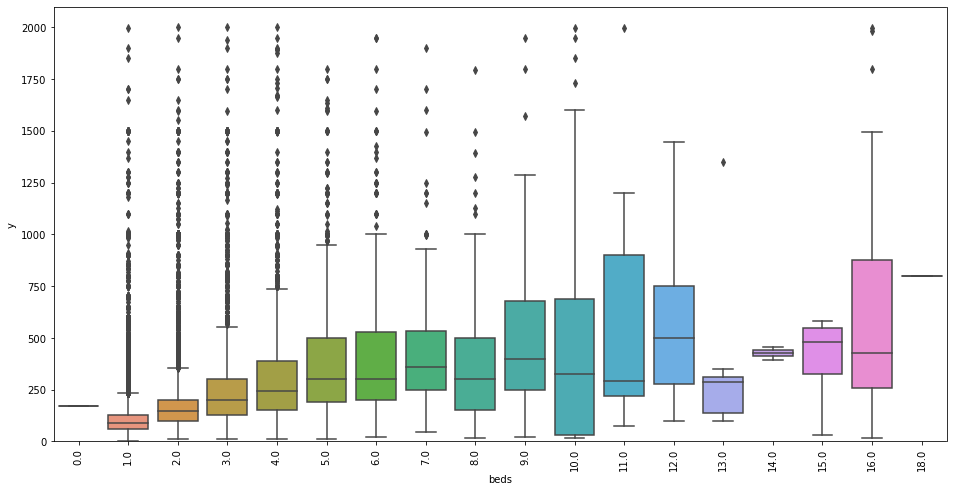

In [11]:
#ベッドの数

var = 'beds'
data = pd.concat([train['y'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='y', data=data)
fig.axis(ymin=0, ymax=2100)
plt.xticks(rotation=90);

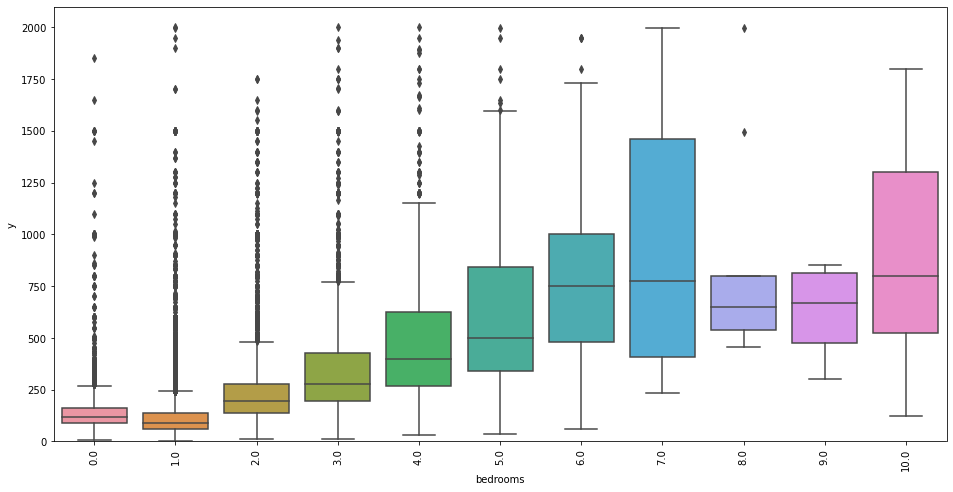

In [12]:
var = 'bedrooms'
data = pd.concat([train['y'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='y', data=data)
fig.axis(ymin=0, ymax=2100)
plt.xticks(rotation=90);

# ここまでのまとめ

1. 相関が高いカラムは全体的に多ければ高い、という結果に
2. これらのカラムを足し合わせて最大最小正規化して多ければ多いほど偉い事評価するカラムを作る
3. それ以上にlatitudeとlongitudeが強いのでどこにあるかの方が影響が大きい
4. 経緯度の重要性は理解しているがモデルを作る上での取り回しが分からない

In [13]:
#yを分離

train_y = train['y']
print(f'y : {train_y.shape}')

y : (55583,)


In [14]:
#重要度の低いカラム、内容が近いカラムを落とす

delete_columns = ['id','y', 'thumbnail_url','zipcode']
all_data.drop(delete_columns,axis=1,inplace=True)

print(f'data size : {all_data.shape}')

data size : (74111, 25)


In [15]:
#日付の文字列を変換

for col in ('first_review' , 'last_review' , 'host_since'):
    all_data[col] = pd.to_datetime(all_data[col])
    all_data[col] = pd.DatetimeIndex(all_data[col])
    all_data[col] = np.log(all_data[col].values.astype(np.float64))
    all_data[col] = all_data[col].fillna(0)

In [16]:
all_data[['first_review' , 'last_review' , 'host_since']].head(5)

#本当はいつから存在するのかとレビュー数を重みにしたい

,first_review,last_review,host_since
0,41.831507,41.831507,41.830683
1,41.834266,41.845924,41.819083
2,41.829034,41.853717,41.827560
3,41.779313,41.854924,41.739249
4,41.810294,41.855326,41.802275


In [17]:
#部屋系カラムの欠損埋め
#ないという事はない、と仮定し1で埋める

for col in ('bathrooms','beds','bedrooms'):
    all_data[col] = all_data[col].fillna(1)

In [18]:
#あるかないかでない部分にNoneを入れる

for col in ('host_response_rate','neighbourhood','host_identity_verified','host_has_profile_pic'):
    all_data[col] = all_data[col].fillna('None')

In [19]:
#スコアの欠損をmedianに置き換える

all_data['review_scores_rating'].fillna(all_data['review_scores_rating'].median(),inplace=True)

In [20]:
#字の長さでカウント
#amenitiesは簡易的に相関を出した時点でスコアが高いのでカラムで細分化する

for col in ('description' , 'name'):
    all_data[col] = all_data[col].apply(lambda x: sum(len(word) for word in str(x).split(' ')))

In [21]:
#残りのobject型の分類をする

all_data.dtypes

accommodates                int64
amenities                  object
bathrooms                 float64
bed_type                   object
bedrooms                  float64
beds                      float64
cancellation_policy        object
city                       object
cleaning_fee               object
description                 int64
first_review              float64
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                float64
instant_bookable           object
last_review               float64
latitude                  float64
longitude                 float64
name                        int64
neighbourhood              object
number_of_reviews           int64
property_type              object
review_scores_rating      float64
room_type                  object
dtype: object

In [22]:
# ラベルエンコーディング

cols =  ('bed_type','cancellation_policy',
        'city','cleaning_fee',
        'host_identity_verified',
        'host_has_profile_pic',
        'host_response_rate',
        'instant_bookable',
        'property_type','room_type',
        'neighbourhood')

for col in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[col].values))
    all_data[col] = lbl.transform(list(all_data[col].values))

all_data.dtypes

accommodates                int64
amenities                  object
bathrooms                 float64
bed_type                    int32
bedrooms                  float64
beds                      float64
cancellation_policy         int32
city                        int32
cleaning_fee                int32
description                 int64
first_review              float64
host_has_profile_pic        int32
host_identity_verified      int32
host_response_rate          int32
host_since                float64
instant_bookable            int32
last_review               float64
latitude                  float64
longitude                 float64
name                        int64
neighbourhood               int32
number_of_reviews           int64
property_type               int32
review_scores_rating      float64
room_type                   int32
dtype: object

In [23]:
#アメニティを小分けにする単品ver.

#all_data['amenities_TV'] = all_data['amenities'].str.contains('TV')
#all_data['amenities_TV'] = all_data['amenities_TV'].apply(lambda x: 1 if x else 0)

#all_data['amenities_TV'].value_counts()

In [24]:
amenities = ['TV', 'Internet', 'parking', '24-hour',
             'Kitchen', 'Pets', 'Safety card', 'Air conditioning',
             'Heating', 'Family', 'Self', '{}']

for i, amenitie in enumerate(amenities):
    new_col = 'amenities_' + amenitie
    all_data[new_col] = all_data['amenities'].str.contains(amenitie)
    all_data[new_col] = all_data[new_col].apply(lambda x: 1 if x else 0)

all_data.drop('amenities',axis=1,inplace=True)

In [25]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 18527
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   accommodates                74111 non-null  int64  
 1   bathrooms                   74111 non-null  float64
 2   bed_type                    74111 non-null  int32  
 3   bedrooms                    74111 non-null  float64
 4   beds                        74111 non-null  float64
 5   cancellation_policy         74111 non-null  int32  
 6   city                        74111 non-null  int32  
 7   cleaning_fee                74111 non-null  int32  
 8   description                 74111 non-null  int64  
 9   first_review                74111 non-null  float64
 10  host_has_profile_pic        74111 non-null  int32  
 11  host_identity_verified      74111 non-null  int32  
 12  host_response_rate          74111 non-null  int32  
 13  host_since                  741

In [26]:
all_data.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,amenities_TV,amenities_Internet,amenities_parking,amenities_24-hour,amenities_Kitchen,amenities_Pets,amenities_Safety card,amenities_Air conditioning,amenities_Heating,amenities_Family,amenities_Self,amenities_{}
0,6,2.0,4,1.0,4.0,0,3,1,304,41.831507,2,1,80,41.830683,0,41.831507,33.788931,-118.154761,12,394,1,0,60.0,1,1,1,1,0,1,0,0,0,0,0,0,0
1,2,1.0,4,1.0,1.0,2,2,1,337,41.834266,2,2,2,41.819083,0,41.845924,38.934810,-76.978190,23,74,9,17,100.0,1,1,1,1,1,1,0,0,1,1,0,0,0
2,2,2.0,4,1.0,1.0,2,4,1,389,41.829034,2,1,2,41.827560,1,41.853717,40.695118,-73.926240,39,84,27,0,83.0,1,1,1,0,1,1,0,1,0,1,0,1,0
3,2,1.0,4,1.0,1.0,2,5,1,817,41.779313,2,2,2,41.739249,1,41.854924,37.796728,-122.411906,31,390,38,0,95.0,1,1,1,0,0,1,0,1,1,1,0,1,0
4,2,1.0,4,1.0,1.0,2,4,1,828,41.810294,2,2,2,41.802275,0,41.855326,40.785050,-73.974691,30,557,5,0,100.0,0,1,1,0,0,1,0,1,1,1,0,0,0


# 仮説から新しい特徴量を作る
1. 部屋の数が多いほど高い指数を作る
2. アメニティはあればあるほど良い

In [27]:
#1
#収容人数に対して部屋やベッドが少ないと低いスコアが出るように調整

#正規化の方が良いかも？
#外れ値への対処方法を考えたい

#sns.displot(all_data['room_index_number']);

all_data['room_index_number'] =  all_data['bathrooms']+all_data['bedrooms']/all_data['accommodates']
all_data['bed/acc'] = all_data['beds']/all_data['accommodates']

cols = ['room_index_number', 'bed/acc']

scl = MinMaxScaler(feature_range=(0, 1),copy=True)
scl.fit(all_data[cols].astype('float64'))
all_data[cols] = scl.transform(all_data[cols])

all_data[cols].head()

,room_index_number,bed/acc
0,0.240741,0.041667
1,0.166667,0.031250
2,0.277778,0.031250
3,0.166667,0.031250
4,0.166667,0.031250


In [28]:
#2
#amenitiesカラムの合計
#良い足し算が思いつかないので力技

all_data['All_amenites'] = all_data['amenities_TV'] + all_data['amenities_Internet'] + all_data['amenities_parking'] + all_data['amenities_24-hour'] +  all_data['amenities_Kitchen'] + all_data['amenities_Pets'] + all_data['amenities_Safety card'] + all_data['amenities_Air conditioning'] + all_data ['amenities_Heating'] + all_data['amenities_Family'] + all_data['amenities_Self'] + all_data['amenities_{}']

In [29]:
all_data

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,amenities_TV,amenities_Internet,amenities_parking,amenities_24-hour,amenities_Kitchen,amenities_Pets,amenities_Safety card,amenities_Air conditioning,amenities_Heating,amenities_Family,amenities_Self,amenities_{},room_index_number,bed/acc,All_amenites
0,6,2.0,4,1.0,4.0,0,3,1,304,41.831507,2,1,80,41.830683,0,41.831507,33.788931,-118.154761,12,394,1,0,60.0,1,1,1,1,0,1,0,0,0,0,0,0,0,0.240741,0.041667,4
1,2,1.0,4,1.0,1.0,2,2,1,337,41.834266,2,2,2,41.819083,0,41.845924,38.934810,-76.978190,23,74,9,17,100.0,1,1,1,1,1,1,0,0,1,1,0,0,0,0.166667,0.031250,7
2,2,2.0,4,1.0,1.0,2,4,1,389,41.829034,2,1,2,41.827560,1,41.853717,40.695118,-73.926240,39,84,27,0,83.0,1,1,1,0,1,1,0,1,0,1,0,1,0,0.277778,0.031250,7
3,2,1.0,4,1.0,1.0,2,5,1,817,41.779313,2,2,2,41.739249,1,41.854924,37.796728,-122.411906,31,390,38,0,95.0,1,1,1,0,0,1,0,1,1,1,0,1,0,0.166667,0.031250,7
4,2,1.0,4,1.0,1.0,2,4,1,828,41.810294,2,2,2,41.802275,0,41.855326,40.785050,-73.974691,30,557,5,0,100.0,0,1,1,0,0,1,0,1,1,1,0,0,0,0.166667,0.031250,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,1.0,4,2.0,2.0,2,4,1,838,0.000000,2,2,2,41.676317,0,0.000000,40.734555,-73.954892,28,238,0,0,96.0,0,1,1,0,0,1,0,0,1,1,1,0,0,0.166667,0.031250,6
18524,2,1.0,4,2.0,1.0,0,1,0,170,41.841626,2,1,2,41.841161,0,41.846561,41.945939,-87.672018,38,299,9,0,90.0,0,1,1,0,0,1,0,0,1,1,1,0,0,0.222222,0.031250,6
18525,5,1.5,4,2.0,2.0,0,1,1,827,0.000000,2,1,2,41.789849,0,0.000000,41.933123,-87.708087,24,27,0,17,96.0,0,1,1,0,0,1,0,0,1,1,1,0,0,0.211111,0.025000,6
18526,2,1.0,4,1.0,2.0,2,4,1,827,41.825433,2,1,2,41.779436,0,41.848124,40.788702,-73.947358,37,165,4,0,95.0,0,0,1,0,0,1,0,0,1,1,1,0,0,0.166667,0.062500,5


In [30]:
#lgbmでエラーがでたカラム名を変える

import re

all_data = all_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
all_data.rename(columns={'amenities_{}':'amenities_X'})

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,amenities_TV,amenities_Internet,amenities_parking,amenities_24hour,amenities_Kitchen,amenities_Pets,amenities_Safetycard,amenities_Airconditioning,amenities_Heating,amenities_Family,amenities_Self,amenities_,room_index_number,bedacc,All_amenites
0,6,2.0,4,1.0,4.0,0,3,1,304,41.831507,2,1,80,41.830683,0,41.831507,33.788931,-118.154761,12,394,1,0,60.0,1,1,1,1,0,1,0,0,0,0,0,0,0,0.240741,0.041667,4
1,2,1.0,4,1.0,1.0,2,2,1,337,41.834266,2,2,2,41.819083,0,41.845924,38.934810,-76.978190,23,74,9,17,100.0,1,1,1,1,1,1,0,0,1,1,0,0,0,0.166667,0.031250,7
2,2,2.0,4,1.0,1.0,2,4,1,389,41.829034,2,1,2,41.827560,1,41.853717,40.695118,-73.926240,39,84,27,0,83.0,1,1,1,0,1,1,0,1,0,1,0,1,0,0.277778,0.031250,7
3,2,1.0,4,1.0,1.0,2,5,1,817,41.779313,2,2,2,41.739249,1,41.854924,37.796728,-122.411906,31,390,38,0,95.0,1,1,1,0,0,1,0,1,1,1,0,1,0,0.166667,0.031250,7
4,2,1.0,4,1.0,1.0,2,4,1,828,41.810294,2,2,2,41.802275,0,41.855326,40.785050,-73.974691,30,557,5,0,100.0,0,1,1,0,0,1,0,1,1,1,0,0,0,0.166667,0.031250,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,1.0,4,2.0,2.0,2,4,1,838,0.000000,2,2,2,41.676317,0,0.000000,40.734555,-73.954892,28,238,0,0,96.0,0,1,1,0,0,1,0,0,1,1,1,0,0,0.166667,0.031250,6
18524,2,1.0,4,2.0,1.0,0,1,0,170,41.841626,2,1,2,41.841161,0,41.846561,41.945939,-87.672018,38,299,9,0,90.0,0,1,1,0,0,1,0,0,1,1,1,0,0,0.222222,0.031250,6
18525,5,1.5,4,2.0,2.0,0,1,1,827,0.000000,2,1,2,41.789849,0,0.000000,41.933123,-87.708087,24,27,0,17,96.0,0,1,1,0,0,1,0,0,1,1,1,0,0,0.211111,0.025000,6
18526,2,1.0,4,1.0,2.0,2,4,1,827,41.825433,2,1,2,41.779436,0,41.848124,40.788702,-73.947358,37,165,4,0,95.0,0,0,1,0,0,1,0,0,1,1,1,0,0,0.166667,0.062500,5


# データを分割

In [31]:
train_new = all_data[:len(train)]
test_new = all_data[len(train):]

In [32]:
train_new.shape

(55583, 39)

In [33]:
test_new.shape

(18528, 39)

In [34]:
model = lgb.LGBMRegressor(num_leaves=100,learning_rate=0.05,n_estimators=1000)
model.fit(train_new,train_y)

LGBMRegressor(learning_rate=0.05, n_estimators=1000, num_leaves=100)

In [35]:
pred = model.predict(test_new)

In [36]:
sample_submit[1]= pred
sample_submit.to_csv('new.csv',index=False,header=None)

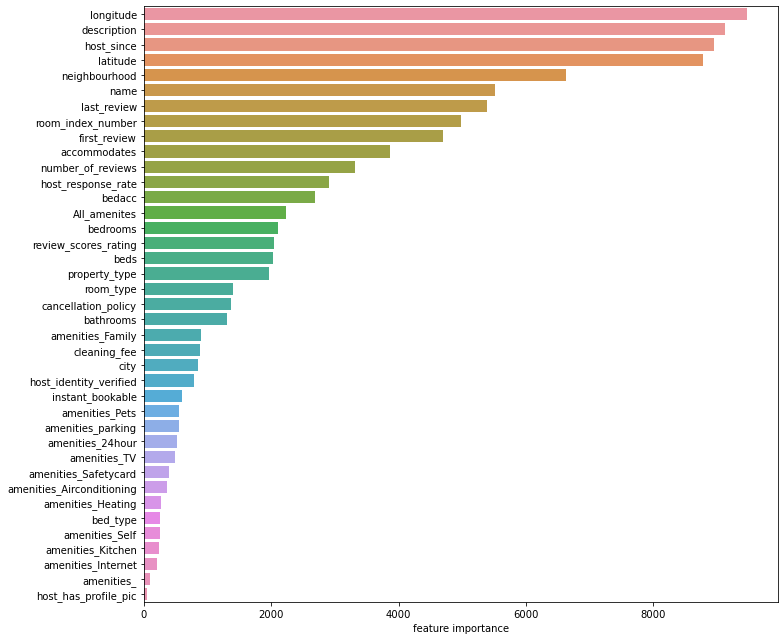

In [37]:
# 変数重要度を可視化
ranking = np.argsort(-model.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=model.feature_importances_[ranking],y=train_new.columns.values[ranking], orient='h')
ax.set_xlabel('feature importance')
plt.tight_layout()
plt.show()